# Introduction

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import math
import sys

In [3]:
import matplotlib.pyplot as plt

# Prepare dataset
## As an example we consider $y = sin(x)$, with $x \sim \mathcal{N}_{0, 0.5}$ and noisy $y$

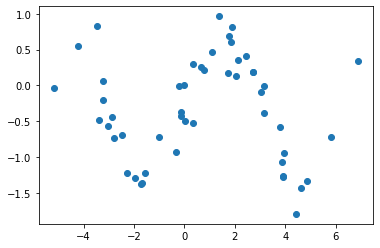

In [42]:
n_points = 50

x = 2*np.pi * np.random.normal(0, 0.5, n_points)
x.sort()
x = x.reshape(n_points, 1)
y = np.sin(x) + np.random.normal(-0.3, 0.3, x.shape)

# Plot to visualise target function
plt.scatter(x,y)

# Convert to tensor for model training
data = torch.Tensor(np.concatenate((x,y),-1))

# Define Bayesian linear layer
## Here we introduce a simple linear layer based on variational inference

In [12]:
class VBLinear(nn.Module):
    def __init__(self, in_features, out_features, prior_prec=1.0, map=True):
        super(VBLinear, self).__init__()
        self.n_in = in_features
        self.n_out = out_features

        self.prior_prec = prior_prec
        self.map = map

        self.bias = nn.Parameter(torch.Tensor(out_features))
        self.mu_w = nn.Parameter(torch.Tensor(out_features, in_features))
        self.logsig2_w = nn.Parameter(torch.Tensor(out_features, in_features))
        
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.mu_w.size(1))
        self.mu_w.data.normal_(0, stdv)
        self.logsig2_w.data.zero_().normal_(-9, 0.001)
        self.bias.data.zero_()
       
    # Define KL divergence between the predicted and the variational posteriors
    def KL(self):
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            kl = 0.5 * (self.prior_prec * (self.mu_w.pow(2) + logsig2_w.exp()) - logsig2_w - 1 - np.log(self.prior_prec)).sum()
            return kl

    def forward(self, input):
        if self.training:
            mu_out = F.linear(input, self.mu_w, self.bias)
            logsig2_w = self.logsig2_w.clamp(-11, 11)
            s2_w = logsig2_w.exp()
            var_out = F.linear(input.pow(2), s2_w) + 1e-8
            return mu_out + var_out.sqrt() * torch.randn_like(mu_out)
        else:
            if self.map:
                return F.linear(input, self.mu_w, self.bias)
            else:
                mu_out = F.linear(input, self.mu_w, self.bias)
                logsig2_w = self.logsig2_w.clamp(-11, 11)
                s2_w = logsig2_w.exp()
                var_out = F.linear(input.pow(2), s2_w) + 1e-8
                return mu_out + var_out.sqrt() * torch.randn_like(mu_out)


# Build model

In [ ]:
class Regressor(nn.Module):
    def __init__(self, n_layers, input_dim, hidden_dim):
        super().__init__()
        self.n_layers   = n_layers
        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
    
    def build_model(self):
        model = nn.ModuleList()
        
        model.append(VBLinear(self.input_dim, self.hidden_dim))
        model.append(nn.ReLU())
        
        for l in range(self.n_layers):
            model.append(VBLinear(self.hidden_dim, self.hidden_dim))
            model.append(nn.ReLU())
            
        model.append(VBLinear(self.hidden_dim, 2))
        
        self.model = model
        self.params_trainable = list(filter(lambda p: p.requires_grad, self.parameters()))
            
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
    def set_optimizer(self):
        lr = 1e-3
        eps = 1e-6
        weight_decay = 0.
        gamma = 0.99
        
        self.optim = torch.optim.Adam(self.params_trainable, 
                                      lr = lr, 
                                      betas=[0.9,0.999],
                                      eps = eps,
                                      weight_decay = weight_decay)
        self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optim,
                                                         step_size=1000,
                                                         gamma=gamma)
            

# Create model

In [49]:
regressor = Regressor(n_layers=0, input_dim=1, hidden_dim=5)
regressor.build_model()
regressor.set_optimizer()

# Print model summary
print(regressor)
print('Total parameters: %d' % sum([np.prod(p.size()) for p in regressor.params_trainable]))

Regressor(
  (model): ModuleList(
    (0): VBLinear()
    (1): ReLU()
    (2): VBLinear()
  )
)
Total parameters: 37


In [8]:
# Train model

In [57]:
print('Epoch\t\tNLL train\tKL \t\t lr')
try:
    for epoch in range(50000):
        
        pred = regressor(data[:,0].view(n_points,1))
        
        target = data[:,1]
        
        mu_pred    = pred[:,0]
        sigma_pred = pred[:,1]
        
        # Compute neg log likelihood on the given dataset
        nll = torch.mean(0.5 * torch.exp(-sigma_pred) * (mu_pred - target)**2 + 0.5 * sigma_pred)
        
        # Add KL divergence
        kl = 0.
        for layer in regressor.model:
            if hasattr(layer, 'KL'):
                kl += layer.KL()
        kl /= n_points
        
        nll += kl
        
        regressor.optim.zero_grad()
        nll.backward()
        regressor.optim.step()
        regressor.scheduler.step()
        
        if not epoch % 1000:
            print('%.3i \t\t%.6f \t%.6f\t %.2e' % (epoch,
                                                nll.item(),
                                                kl.item(),
                                                regressor.optim.param_groups[0]['lr']), flush=True)
except:
    raise

Epoch		NLL train	KL 		 lr
000 		-0.081125 	0.475991	 1.48e-03
1000 		-0.014097 	0.475185	 1.47e-03
2000 		-0.072876 	0.475557	 1.45e-03
3000 		-0.127544 	0.474763	 1.44e-03
4000 		-0.092283 	0.471362	 1.42e-03
5000 		-0.015521 	0.470544	 1.41e-03
6000 		0.008160 	0.470249	 1.39e-03
7000 		-0.022415 	0.471483	 1.38e-03
8000 		-0.032130 	0.470975	 1.37e-03
9000 		-0.116938 	0.473639	 1.35e-03
10000 		-0.085560 	0.471198	 1.34e-03
11000 		-0.062102 	0.470242	 1.33e-03
12000 		-0.012726 	0.471159	 1.31e-03
13000 		0.034963 	0.470910	 1.30e-03
14000 		-0.075601 	0.470167	 1.29e-03
15000 		-0.132122 	0.469709	 1.27e-03
16000 		-0.121324 	0.471319	 1.26e-03
17000 		0.009142 	0.471009	 1.25e-03
18000 		-0.126208 	0.471809	 1.24e-03
19000 		-0.073409 	0.472530	 1.22e-03
20000 		0.010356 	0.470761	 1.21e-03
21000 		-0.095836 	0.469427	 1.20e-03
22000 		-0.073372 	0.470970	 1.19e-03
23000 		-0.091410 	0.470769	 1.18e-03
24000 		0.025456 	0.471980	 1.16e-03
25000 		-0.101683 	0.471956	 1.15e-03
26

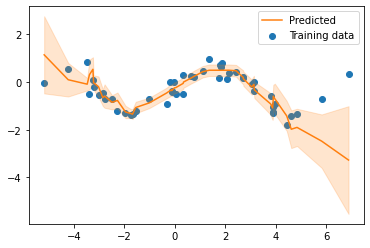

In [55]:
pred = regressor(torch.Tensor(x).view(n_points,1)).detach().numpy()
mu_pred = pred[:,0]
sigma_pred = np.exp(pred[:,1])**0.5

x = x.flatten()
y = y.flatten()

plt.scatter(x, y, label='Training data')
plt.plot(x, mu_pred, color='C1', label='Predicted')
plt.fill_between(x, mu_pred - sigma_pred , mu_pred + sigma_pred, alpha=0.2, color='C1')
plt.legend()